
# Rollout Starting Demo

This notebook demonstrates our code's basic features by computing the rollout of expected improvement (EI) for horizon two. Let $y^*$ represent the current observed minimum and $(\cdot)^+ = \text{max}(\cdot, 0)$. Recall that EI is defined as $\text{EI}(\mathbf{x}) = \mathbb{E}[\big(y^* - y(\mathbf{x})\big)^+]$; that is, the expected reduction in the objective over the next step of BO. We define rollout for horizon two as:

$$ \text{EI}_2(\mathbf{x}) = \mathbb{E}[\big(y^* - y_1(\mathbf{x}_1)\big)^+]. $$

Our expectation is taken recursively with respect to $y_1$, which depends on $\mathbf{x}_1$, itself defined as:
    
$$\mathbf{x}_1 = \text{argmax } \text{EI} (\mathbf{x} \;|\; y(\mathbf{x})).$$

Thus, $\text{EI}_2(\mathbf{x})$ computes the expected reduction in the objective over the next two steps of BO, assuming EI is maximized at $\mathbf{x}$. $\text{EI}_2(\mathbf{x})$ has no analytic form, and so we estimate it via Monte Carlo integration (MC) as the average of $N$ sample paths. Each sample path has the following form: $y^{(i)} \rightarrow \mathbf{x}_1^{(i)} \rightarrow y_1^{(i)}$. $y^{(i)}$ is sampled from the GP posterior, $\mathbf{x}_1^{(i)}$ is chosen deterministically by maximizing EI, and then $y_1^{(i)}$ is sampled from the updated GP posterior at $\mathbf{x}_1^{(i)}$: 

$$ \text{EI}_2(\mathbf{x}) \approx \frac{1}{N}\sum_{i=1}^N\big(y^* - y_1^{(i)}(\mathbf{x}^{(i)}_1)\big)^+. $$

Our demo follows.

In [1]:
# Basic import statements
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Code overview

The name of our package is `lookahead`, and is roughly based off of [Cornell MOE](https://github.com/wujian16/Cornell-MOE). `lookahead.acquisitions` contains the expected improvement, upper confidence bound, knowledge gradient, probability of improvement, and rollout acquisition functions. `lookahead.models` contains the necessary Gaussian process (GP) code. 

Below, we import two acquisition functions: EI and rollout of EI. We then import our GP wrapper, and defined our optimization domain as the unit hypercube in 1D. *Note*: our code will always assume that the data is normalized to the unit hypercube, and will not work otherwise. 

In [2]:
from lookahead.acquisitions.expected_improvement import ExpectedImprovement
from lookahead.acquisitions.rollout_ei_vr import RolloutEI_VR as RolloutEI
from lookahead.model.gaussian_process import GaussianProcessSimple as GP
from lookahead.model.domain import ClosedInterval, TensorProductDomain
opt_domain = TensorProductDomain([ClosedInterval(0, 1)])

# A toy problem

Below, we build a GP assuming we have two observations at 0.15 and 0.85, both of which have value zero. Note that we fix the GP's hypers instead of learning them, for illustrative purposes. We plot the GP's mean in red, shade its uncertainty in magenta, and mark the two observations in black. 

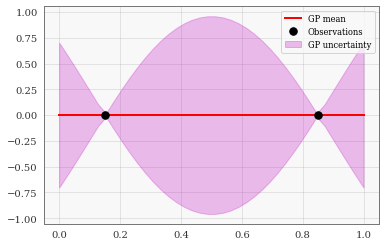

In [3]:
fig, ax = plt.subplots(1, 1)
xtrain = np.linspace(0.15, 0.85, 2)[:, None]
ytrain = np.array([0, 0])
gp = GP(xtrain, ytrain)
gp.set_hypers([5, 0.25])
x = np.linspace(0, 1, 40)[:, None]
y_gp = gp.mean(x)
y_var = np.sqrt(gp.variance(x))
_ = ax.plot(x, y_gp, color='r')
_ = ax.plot(xtrain, ytrain, 'k.', markersize=15)
_ = ax.fill_between(x[:, 0], y_gp - y_var, y_gp + y_var, color='m', alpha=0.25)
_ = ax.legend(['GP mean','Observations','GP uncertainty'])

# Comparing EI and Rollout EI

Next, we plot the contours of both EI and Rollout EI for horizon 2 (EI2). EI2 is computed with Monte Carlo integration, combined with the variance reduction techniques we describe in our paper to make its computation quick. Notice that whereas EI favors sampling in the middle of the domain, EI2 favors sampling away from the middle of the domain! Note that EI2 will look a little noisy, because we are estimating it very quickly.  

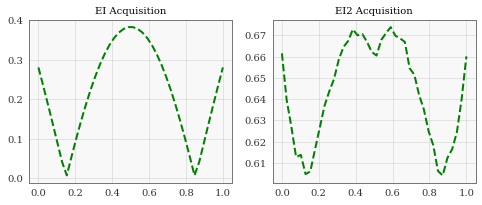

In [4]:
(fig, ax) = plt.subplots(1, 2, figsize=(8, 3))
ei = ExpectedImprovement(gp, opt_domain)
ei_vals = ei.evaluate_at_point_list(x)

# We estimate EI2 using 100 MC iterations, using grid search of size 50 to maximize the inner EI
ei2 = RolloutEI(gp, opt_domain, horizon=2, opt_mode='grid', mc_iters=20, grid_size=100)
ei2_vals = ei2.evaluate_at_point_list(x)

_ = ax[0].plot(x, ei_vals, '--g')
_ = ax[1].plot(x, ei2_vals, '--g')
_ = ax[0].set_title('EI Acquisition')
_ = ax[1].set_title('EI2 Acquisition')